## やってみた結果
共分散行列を共有 or 2つ用意で変えてみても、あまり結果が変わらなかった。  
Andrew先生曰く、クラスごとに用意するとdecision boundaryが非線形になるらしいけど、あれ？

## 必要な式一覧
正規分布の共分散行列が$y=0$と$y=1$で同じ場合。
$$
\begin{align}
p(x|y=0) &= \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{0})^{T}\Sigma^{-1}(x-\mu_{0})) \\
p(x|y=1) &= \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{1})^{T}\Sigma^{-1}(x-\mu_{1})) \\
p(y) &= \phi^{y}(1-\phi)^{1-y} \\
\phi &= \frac{1}{m}\sum_{i=1}^{m}y^{(i)} = \frac{1}{m}\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\} \\
\mu_{0} &= \frac{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=0\}x^{(i)}}{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=0\}} \\
\mu_{1} &= \frac{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\}x^{(i)}}{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\}} \\
\Sigma &= \frac{1}{m}\sum_{i=1}^{m}(x^{(i)}-\mu_{y^{(i)}})(x^{(i)}-\mu_{y^{(i)}})^{T} \\
\end{align}
$$

正規分布の共分散行列が$y=0$と$y=1$で異なる場合。  
（上と異なる部分のみ記載、特に共分散行列が合っているか微妙）
$$
\begin{align}
p(x|y=0) &= \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma_{0}|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{0})^{T}\Sigma_{0}^{-1}(x-\mu_{0})) \\
p(x|y=1) &= \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma_{1}|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{1})^{T}\Sigma_{1}^{-1}(x-\mu_{1})) \\
\Sigma_{0} &= \frac{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=0\}(x^{(i)}-\mu_{0})(x^{(i)}-\mu_{0})^{T}}{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=0\}} \\
\Sigma_{1} &= \frac{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\}(x^{(i)}-\mu_{1})(x^{(i)}-\mu_{1})^{T}}{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\}} \\
\end{align}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
# GDAを実装する
class GDAwithSharedSigma:
    """sigmaを共有したbinaryのGDAを実装する"""
    def fit(self, Xs, ys):
        self.phi = np.mean(ys)
        self.mu0 = np.mean([X for X, y in zip(Xs, ys) if y == 0], axis=0)
        self.mu1 = np.mean([X for X, y in zip(Xs, ys) if y == 1], axis=0)
        self.sigma = np.mean([
            outer_product(X - (self.mu0 if y == 0 else self.mu1))
            for X, y in zip(Xs, ys)
        ], axis=0)

    def __call__(self, Xs):
        preds = []
        for X in Xs:
            prob0 = gaussian(X, self.mu0, self.sigma) * bernoulli(0, self.phi)
            prob1 = gaussian(X, self.mu1, self.sigma) * bernoulli(1, self.phi)
            preds.append(0 if prob0 > prob1 else 1)

        return preds


class GDAwithDifferentSigma:
    """sigmaの値を2つ用意したGDAを実装する"""
    def fit(self, Xs, ys):
        self.phi = np.mean(ys)
        self.mu0 = np.mean([X for X, y in zip(Xs, ys) if y == 0], axis=0)
        self.mu1 = np.mean([X for X, y in zip(Xs, ys) if y == 1], axis=0)
        self.sigma0 = np.mean([
            outer_product(X - self.mu0) for X, y in zip(Xs, ys) if y == 0
        ], axis=0)
        self.sigma1 = np.mean([
            outer_product(X - self.mu1) for X, y in zip(Xs, ys) if y == 1
        ], axis=0)

    def __call__(self, Xs):
        preds = []
        for X in Xs:
            prob0 = gaussian(X, self.mu0, self.sigma0) * bernoulli(0, self.phi)
            prob1 = gaussian(X, self.mu1, self.sigma1) * bernoulli(1, self.phi)
            preds.append(0 if prob0 > prob1 else 1)

        return preds


def outer_product(vector):
    """同じベクトルで外積を作りたかった"""
    return np.outer(vector, vector)


def gaussian(X, mu, sigma):
    """scipy.stats.multivariate_normalとほぼ同じ値が出力される"""
    numerator = np.e ** ((X - mu) @ np.linalg.inv(sigma) @ (X - mu) / -2)
    denominator = (np.linalg.det(sigma) * (2 * np.pi) ** len(X)) ** 0.5
    return numerator / denominator


def bernoulli(y, phi):
    return phi if y == 1 else 1 - phi

In [4]:
# 描画用関数を作成する
def plot(gda, Xs):
    xmin, xmax = Xs.T[0].min(), Xs.T[0].max()
    ymin, ymax = Xs.T[1].min(), Xs.T[1].max()

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.scatter(Xs0.T[0], Xs0.T[1], color='blue')
    plt.scatter(Xs1.T[0], Xs1.T[1], color='red')

    def plt_contour(mean, cov, cmap):
        N = 200
        X = np.linspace(xmin, xmax, N)
        Y = np.linspace(ymin, ymax, N)
        X, Y = np.meshgrid(X, Y)
        pos = np.dstack((X, Y))
        rv = multivariate_normal(mean=mean, cov=cov)
        Z = rv.pdf(pos)
        plt.contour(X, Y, Z, cmap=cmap)

    if hasattr(gda, 'sigma'):
        plt_contour(gda.mu0, gda.sigma, 'Blues')
        plt_contour(gda.mu1, gda.sigma, 'Reds')
    else:
        plt_contour(gda.mu0, gda.sigma0, 'Blues')
        plt_contour(gda.mu1, gda.sigma1, 'Reds')

    plt.show()

In [5]:
# データを準備する
mean0 = [2, 0]
mean1 = [3, 3]
cov = [[1, 0], [0, 1]]
size = 80

Xs0 = np.random.multivariate_normal(mean=mean0, cov=cov, size=size)
ys0 = [0] * size
Xs1 = np.random.multivariate_normal(mean=mean1, cov=cov, size=size)
ys1 = [1] * size

Xs = np.concatenate([Xs0, Xs1], axis=0)
ys = ys0 + ys1

まず共分散行列を共有しているGDAの結果を描画する。

In [6]:
gda = GDAwithSharedSigma()
gda.fit(Xs, ys)

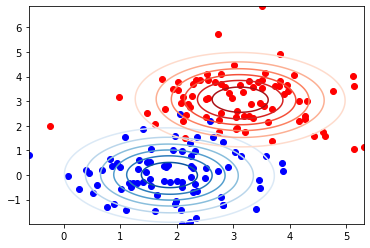

In [7]:
plot(gda, Xs)

次に共分散行列を2つ用意したGDAの結果を描画する。

In [8]:
gda = GDAwithDifferentSigma()
gda.fit(Xs, ys)

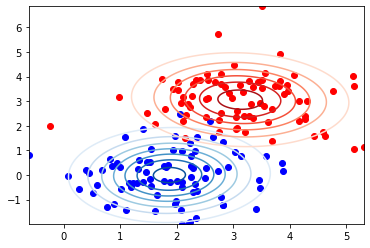

In [9]:
plot(gda, Xs)